---

## PPL's N stuff


In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import equinox as eqx
import numpyro
numpyro.set_host_device_count(2)

from chainconsumer import ChainConsumer
from numpyro import distributions as dist, infer

In [2]:
class Optimiser(eqx.Module):
    model : object
    
    def __init__(self, model):
        self.model = model
    
    def update_params(self, position=None, 
                            separation=None, 
                            field_angle=None, 
                            flux=None,
                            flux_ratio=None, 
                            coeffs=None, 
                            ):
        """
        """
        
        params = (position    if position    is not None else self.model.scene.sources['Binary'].position,
                  separation  if separation  is not None else self.model.scene.sources['Binary'].separation,
                  field_angle if field_angle is not None else self.model.scene.sources['Binary'].field_angle,
                  flux        if flux        is not None else self.model.scene.sources['Binary'].flux,
                  flux_ratio  if flux_ratio  is not None else self.model.scene.sources['Binary'].flux_ratio,
                  coeffs      if coeffs      is not None else self.model.optics.layers['Apply Basis OPD'].coeffs)

        param_paths = lambda obj: (obj.model.scene.sources['Binary'].position,
                                   obj.model.scene.sources['Binary'].separation,
                                   obj.model.scene.sources['Binary'].field_angle,
                                   obj.model.scene.sources['Binary'].flux,
                                   obj.model.scene.sources['Binary'].flux_ratio,
                                   obj.model.optics.layers['Apply Basis OPD'].coeffs)
        
        return eqx.tree_at(param_paths, self, params)
    
    def update_and_model(self, position=None, 
                               separation=None, 
                               field_angle=None, 
                               flux=None,
                               flux_ratio=None, 
                               coeffs=None,
                               
                               flatten=True, # Flattens for single plate
                               ):
        
        self = self.update_params(position=position, 
                                  separation=separation, 
                                  field_angle=field_angle, 
                                  flux=flux,
                                  flux_ratio=flux_ratio, 
                                  coeffs=coeffs,
                                  )
        psf = self.model.model_scene()
        if flatten:
            return psf.flatten()
        else:
            return psf

In [3]:
import dLux as dl
from base import *
from spectrums import *
from sources import *

# Combined Spectrum for Binary
nwavels = 5
wavels = np.linspace(4, 5, nwavels)
wavelengths = [wavels, wavels]
weights = [np.ones(nwavels), np.linspace(0.5, 1, nwavels)]
combined_spectrum = CombinedSpectrum(wavelengths, weights)

# Binary Source
true_position = np.zeros(2)
true_separation = 4
true_field_angle = 0

true_flux = 1
true_flux_ratio = 2

resolved = [False, False]
binary_source = BinarySource(true_position, true_flux, true_separation, true_field_angle, 
                             true_flux_ratio, combined_spectrum, resolved, name="Binary")

# Combine into Scene
scene = Scene([binary_source])

# Optical system
wf_npix = 256
det_npix = 32
basis = dl.utils.zernike_basis(10, npix=wf_npix)[3:] * 1e-6
true_coeffs = np.zeros(len(basis))
layers = [dl.CreateWavefront(wf_npix, 1),
          dl.TiltWavefront(),
          dl.CompoundAperture([0.5]),
          dl.ApplyBasisOPD(basis, true_coeffs),
          dl.NormaliseWavefront(),
          dl.AngularMFT(1, det_npix)]
osys = Optics(layers)
telescope = Telescope(osys, scene)
optimiser = Optimiser(telescope)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


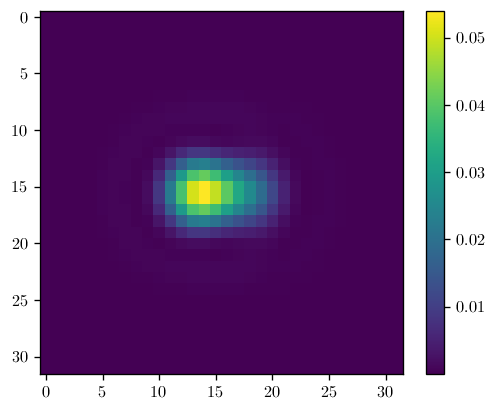

In [17]:
psf = telescope.model_scene()
data = psf.flatten()

plt.figure(figsize=(5, 4))
plt.imshow(psf)
plt.colorbar()
plt.show()

In [5]:
from numpyro.infer.reparam import TransformReparam, LocScaleReparam

def psf_model(data, model=None):
    """
    """
    position    = numpyro.sample("position",    dist.Normal(true_position,    1))
    separation  = numpyro.sample("separation",  dist.Normal(true_separation,  1))
    field_angle = numpyro.sample("field_angle", dist.Normal(true_field_angle, 1))
    flux        = numpyro.sample("flux",        dist.Normal(true_flux,        1))
    flux_ratio  = numpyro.sample("flux_ratio",  dist.Normal(true_flux_ratio,  1))
    coeffs      = numpyro.sample("coeffs",      dist.Normal(true_coeffs,      1))
    
    with numpyro.plate("data", len(data)):
        numpyro.sample("psf", dist.Poisson(model.update_and_model(
                                                            position=position, 
                                                            separation=separation, 
                                                            field_angle=field_angle, 
                                                            flux=flux,
                                                            flux_ratio=flux_ratio, 
                                                            coeffs=coeffs
                                                            )), obs=data)
        
# LocScaleReparam with centered=0 fully "decenters" the prior over separation.
config = {"separation": LocScaleReparam(centered=0)}
psf_model_rep = numpyro.handlers.reparam(psf_model, config=config)

In [6]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(psf_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), data, model=optimiser)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 22min 15s, sys: 1min 37s, total: 23min 53s
Wall time: 4min 31s


In [7]:
sampler.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
    coeffs[0]     -0.02      0.99     -0.02     -1.52      1.74   6103.49      1.00
    coeffs[1]     -0.02      0.99     -0.03     -1.53      1.66   5411.64      1.00
    coeffs[2]     -0.00      1.00      0.00     -1.62      1.61   4654.63      1.00
    coeffs[3]     -0.01      1.04     -0.01     -1.69      1.70   4997.46      1.00
    coeffs[4]     -0.01      1.04     -0.00     -1.78      1.66   4864.43      1.00
    coeffs[5]      0.03      0.98      0.04     -1.51      1.68   5353.07      1.00
    coeffs[6]      0.01      0.98      0.01     -1.67      1.58   5044.89      1.00
  field_angle      0.01      0.87      0.01     -1.38      1.50   4276.65      1.00
         flux      1.21      0.57      1.14      0.22      2.00   3392.48      1.00
   flux_ratio      2.07      0.91      2.03      0.56      3.49   3159.07      1.00
  position[0]      0.09      0.90      0.10     -1.31      1.62   4947.67  

In [18]:
values_out = sampler.get_samples()
list(values_out.keys())

['coeffs', 'field_angle', 'flux', 'flux_ratio', 'position', 'separation']

In [10]:
znames = ['Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX']

new_dict = {
    'Pos$_x$'             : values_out['position'][:, 0],
    'Pos$_y$'             : values_out['position'][:, 1],
    'r'                   : values_out['separation'],
    r'$\phi$'             : values_out['field_angle'],
    'Contrast'            : values_out['flux_ratio'],
    r'$\overline{flux}$'  : values_out['flux'],
}

for i in range(len(znames)):
    new_dict[znames[i]] = values_out['coeffs'][:, i]

truths = {}
keys = list(new_dict.keys())
for i in range(len(keys)):
    if keys[i] == 'r':
        truths['r'] = true_separation
    elif keys[i] == '$\\phi$':
        truths['$\\phi$'] = true_field_angle
    elif keys[i] == 'Contrast':
        truths['Contrast'] = true_flux_ratio
    elif keys[i] == '$\\overline{flux}$':
        truths['$\\overline{flux}$'] = true_flux
    if keys[i] == 'Pos$_x$':
        truths['Pos$_x$'] = true_position[0]
    if keys[i] == 'Pos$_y$':
        truths['Pos$_y$'] = true_position[1]

for i in range(len(znames)):
    truths[znames[i]] = true_coeffs[i]

In [11]:
plt.figure()
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120

<Figure size 432x288 with 0 Axes>

In [12]:
c = ChainConsumer()
c.add_chain(new_dict)
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3);

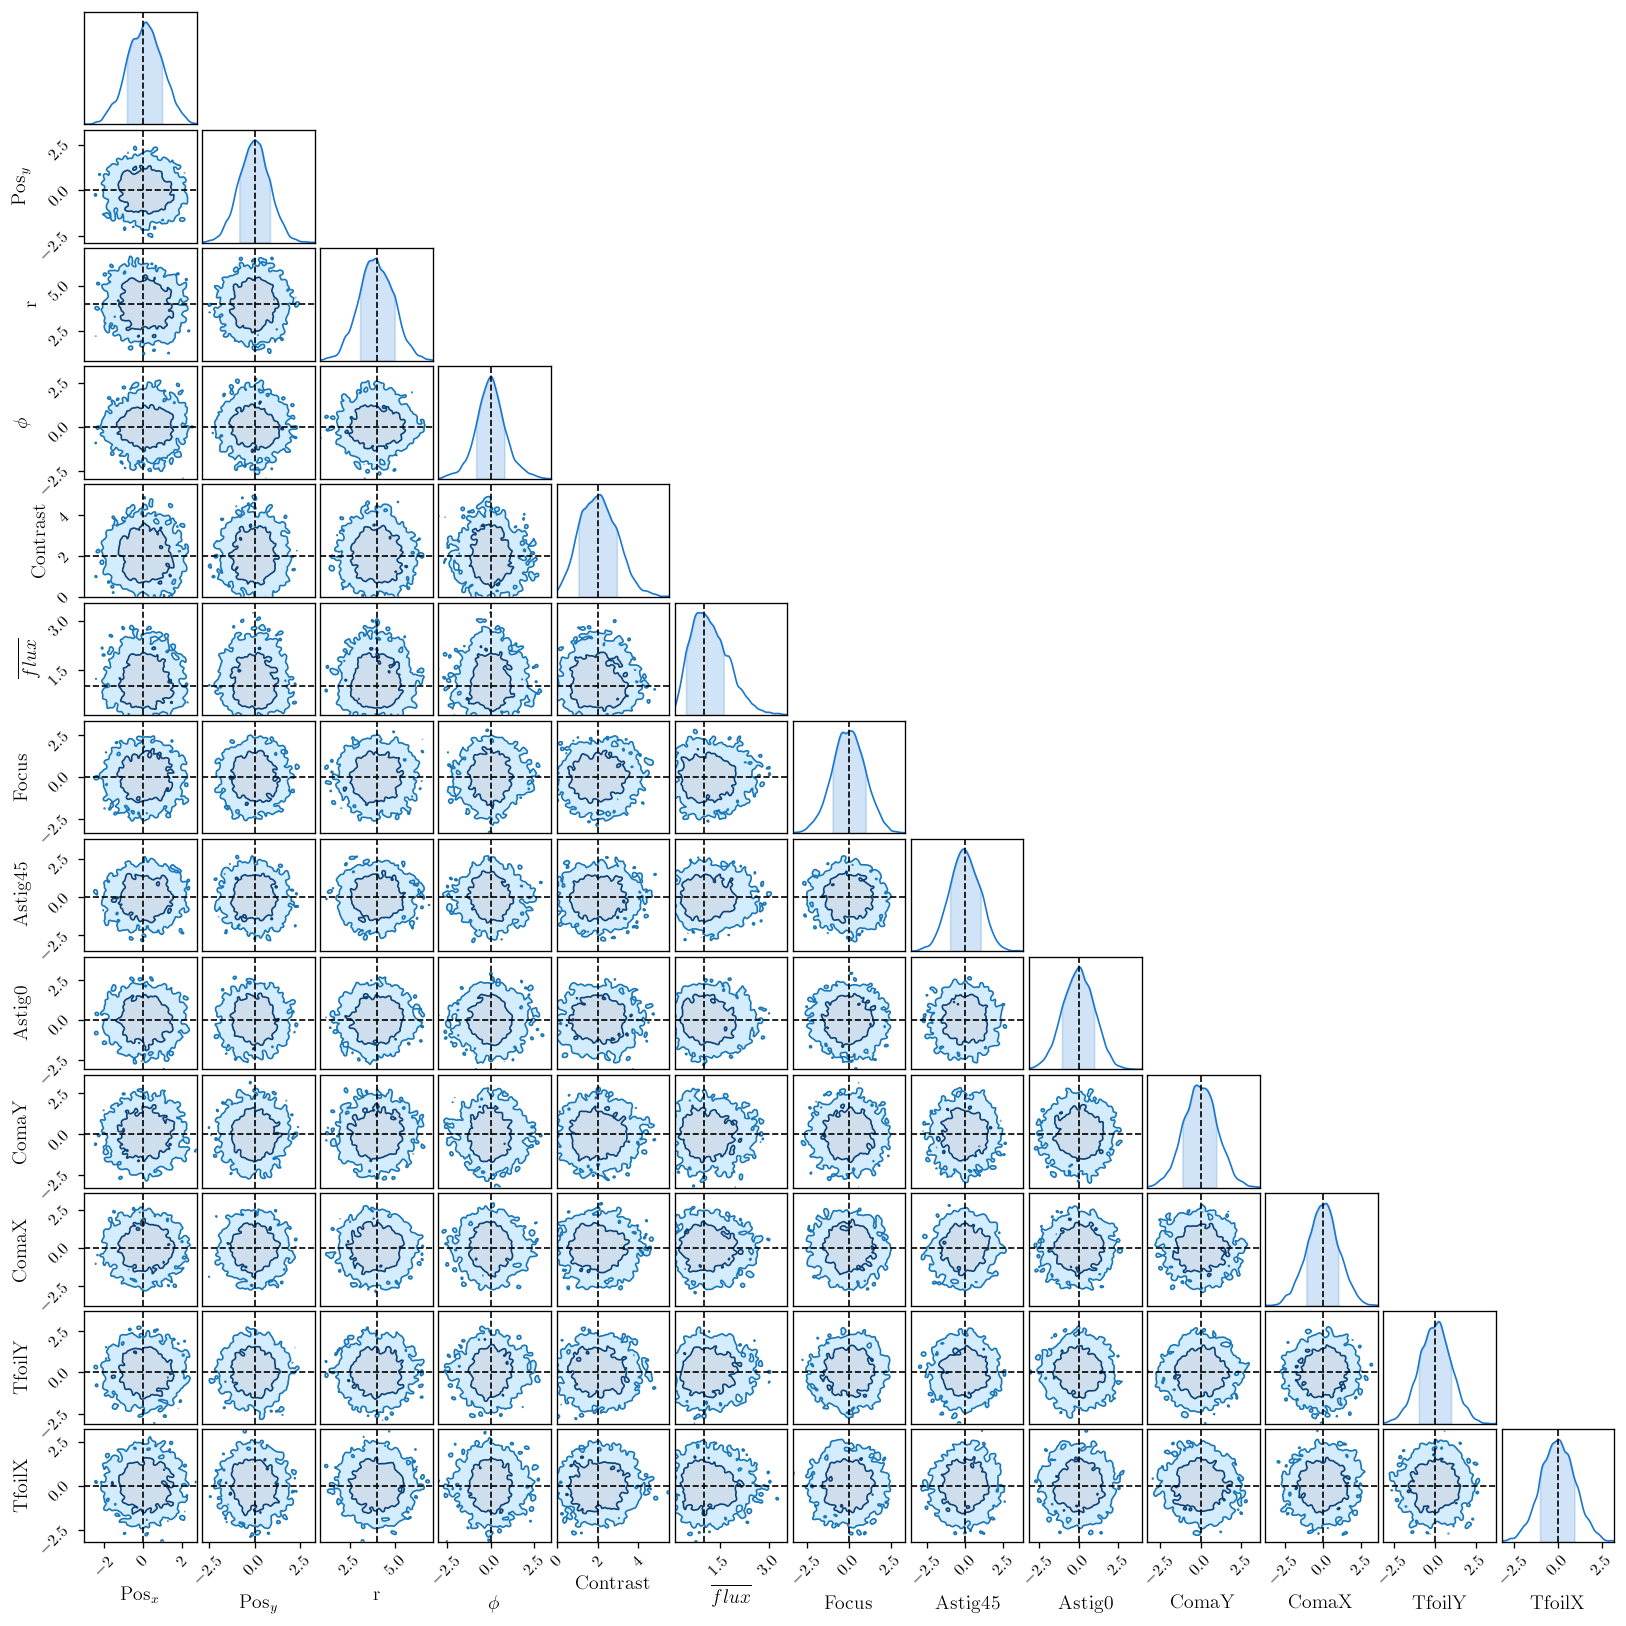

In [15]:
fig = c.plotter.plot(truth=truths)
fig.set_size_inches((15,15))

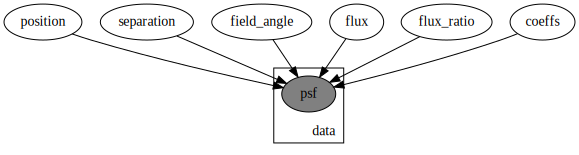

In [14]:
numpyro.render_model(psf_model, model_args=(data, optimiser))